<a href="https://colab.research.google.com/github/zeeshanzaidi92/YorkML_Classification/blob/main/Heart_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
!pip install pycaret -q

     |████████████████████████████████| 266 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 14.6 MB 239 kB/s 
     |████████████████████████████████| 111 kB 38.0 MB/s 
     |████████████████████████████████| 271 kB 38.1 MB/s 
     |████████████████████████████████| 80 kB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 54.6 MB/s 
     |████████████████████████████████| 261 kB 54.5 MB/s 
     |████████████████████████████████| 167 kB 50.0 MB/s 
     |████████████████████████████████| 6.8 MB 23.9 MB/s 
     |████████████████████████████████| 2.0 MB 74.2 MB/s 
     |████████████████████████████████| 1.7 MB 43.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 54.9 MB/s 
     |████████████████████████████████| 3.1 MB 28.0 MB/s 
     |██████████████████

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q

     - 34.6 MB 631 kB/s
     |████████████████████████████████| 4.7 MB 5.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd

from pycaret.classification import *
from pandas_profiling import ProfileReport
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
# running this fixed the plots not displaying
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
plt.close('all')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#profile = ProfileReport(dataset, title="Heart Dataset", html={'style': {'full_width': True}})
#profile.to_notebook_iframe()
#profile.to_file(output_file="Heart_UCI_Profile.html")

# Data Import/Setup

In [ ]:
df_path = 'gdrive/My Drive/Colab Notebooks/heart_cleveland_upload.csv'  #change dir to your project folder
dataset = pd.read_csv(df_path)
dataset.shape

(297, 14)

In [ ]:
dataset.head(1)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   

   ca  thal  condition  
0   1     0          0

In [ ]:
# Rename categorical modes for better graphs - run only Once! else get nulls
dataset.sex = dataset.sex.map({0:'Female',1:'Male'})
dataset.cp = dataset.cp.map({3:'Asymptomatic', 1:'Atypical', 2:'Not Anginal', 0:'Typical'})
dataset.fbs = dataset.fbs.map({0:'<120mg',1:'120mg+'})
dataset.restecg= dataset.restecg.map({0:'Normal',1:'ST Abnormality',2:'LV Hypertrophy'})
dataset.exang = dataset.exang.map({0:'No',1:'Yes'})
dataset.slope = dataset.slope.map({0:'Upslope',1:'Flat',2:'Downslope'})
dataset.thal = dataset.thal.map({1:'Fixed Defect',0:'Normal',2:'Reversable Defect'})
#dataset.condition = dataset.condition.map({0:1, 1:0}) #Reverse order for better graph display?
dataset.condition = dataset.condition.map({0:'No Disease', 1:'Disease'})

# bin oldpeak
bins= [-0.1,0.1,1.7,np.inf]
names=["None","Low","High"]
dataset.oldpeak=pd.cut(dataset.oldpeak, bins, labels=names)

# Renaming columns
dataset.columns = ['Age', 'Gender', 'Chest_Pain', 'Blood_Pressure', 'Cholesterol', 'Blood_Sugar', 'Rest_ECG', 'Max_Heart_Rate',
       'Exercise_Angina', 'ST_Depression', 'ST_Slope', 'Marked_Vessels', 'Thalassemia', 'Heart_Disease']

dataset.head(4)

Age  Gender Chest_Pain  Blood_Pressure  Cholesterol Blood_Sugar  \
0   69    Male    Typical             160          234      120mg+   
1   69  Female    Typical             140          239      <120mg   
2   66  Female    Typical             150          226      <120mg   
3   65    Male    Typical             138          282      120mg+   

         Rest_ECG  Max_Heart_Rate Exercise_Angina ST_Depression   ST_Slope  \
0  LV Hypertrophy             131              No          None       Flat   
1          Normal             151              No          High    Upslope   
2          Normal             114              No          High  Downslope   
3  LV Hypertrophy             174              No           Low       Flat   

   Marked_Vessels Thalassemia Heart_Disease  
0               1      Normal    No Disease  
1               2      Normal    No Disease  
2               0      Normal    No Disease  
3               1      Normal       Disease

In [ ]:
data = dataset.sample(frac=0.90, random_state=54321)
data_unseen = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (267, 14)
Unseen Data For Predictions (30, 14)


In [ ]:
data.head(1)

Age  Gender    Chest_Pain  Blood_Pressure  Cholesterol Blood_Sugar  \
0   62  Female  Asymptomatic             150          244      <120mg   

  Rest_ECG  Max_Heart_Rate Exercise_Angina ST_Depression ST_Slope  \
0   Normal             154             Yes           Low     Flat   

   Marked_Vessels Thalassemia Heart_Disease  
0               0      Normal       Disease

In [ ]:
#Decision:  We dropped the "fbs" column because in a small dataset there is are only two values and they are split into a 85.5%/14.5% split. On a small data set this is likely to skew the results

#data.drop('Blood_Sugar', axis=1, inplace=True)
#data.head(1)



In [ ]:
#Decision:  Tuning notes:
#



#Set variable for name of target column
TARGET_COLUMN = 'Heart_Disease'

exp_clf102 = setup(
      data = data, 
      target = TARGET_COLUMN, 
#      feature_selection = True,
#      feature_selection_threshold = .5,
#      pca = True, 
#      pca_components = .999, 
#      combine_rare_levels = True, 
#      rare_level_threshold = 0.05,
#      ignore_features = ['oldpeak'],
      normalize = True, 
#      transformation = True, 
      remove_multicollinearity = True, 
#      multicollinearity_threshold = 0.70,
      numeric_features = ['Marked_Vessels'],
      bin_numeric_features = ['Age'],
#      profile=True,
      silent=True,
      train_size = 0.9,
      #log_experiment = True,
      #experiment_name = 'P1_Heart',
      session_id=123)

Description                      Value
0                               session_id                        123
1                                   Target              Heart_Disease
2                              Target Type                     Binary
3                            Label Encoded  Disease: 0, No Disease: 1
4                            Original Data                  (267, 14)
5                           Missing Values                      False
6                         Numeric Features                          5
7                     Categorical Features                          8
8                         Ordinal Features                      False
9                High Cardinality Features                      False
10                 High Cardinality Method                       None
11                   Transformed Train Set                  (240, 31)
12                    Transformed Test Set                   (27, 31)
13                      Shuffle Train-Test                       True
14                     Stratify Train-Test                      False
15                          Fold Generator            StratifiedKFold
16                             Fold Number                         10
17                                CPU Jobs                         -1
18                                 Use GPU                      False
19                          Log Experiment                      False
20                         Experiment Name           clf-default-name
21                                     USI                       49c8
22                         Imputation Type                     simple
23          Iterative Imputation Iteration                       None
24                         Numeric Imputer                       mean
25      Iterative Imputation Numeric Model                       None
26                     Categorical Imputer                   constant
27  Iterative Imputation Categorical Model                       None
28           Unknown Categoricals Handling             least_frequent
29                               Normalize                       True
30                        Normalize Method                     zscore
31                          Transformation                      False
32                   Transformation Method                       None
33                                     PCA                      False
34                              PCA Method                       None
35                          PCA Components                       None
36                     Ignore Low Variance                      False
37                     Combine Rare Levels                      False
38                    Rare Level Threshold                       None
39                         Numeric Binning                       True
40                         Remove Outliers                      False
41                      Outliers Threshold                       None
42                Remove Multicollinearity                       True
43             Multicollinearity Threshold                        0.9
44             Remove Perfect Collinearity                       True
45                              Clustering                      False
46                    Clustering Iteration                       None
47                     Polynomial Features                      False
48                       Polynomial Degree                       None
49                    Trignometry Features                      False
50                    Polynomial Threshold                       None
51                          Group Features                      False
52                       Feature Selection                      False
53                Feature Selection Method                    classic
54            Features Selection Threshold                       None
55                     Feature Interaction                      False
56                           Feature Rati

# Compare models

In [ ]:
#Compare models common parameters 
#Decision:  Num folds = 10 because
#Decision: Optimize_for = Accuracy because
NUM_FOLDS = 10
OPTIMIZE_FOR = 'Accuracy'

In [ ]:
top3 = compare_models(
      fold=NUM_FOLDS,
      n_select=3,
      sort=OPTIMIZE_FOR,
      turbo=False)

Model  Accuracy     AUC  Recall   Prec.  \
rbfsvm                SVM - Radial Kernel    0.8250  0.9210  0.8615  0.8336   
rf               Random Forest Classifier    0.8167  0.8934  0.8462  0.8340   
knn                K Neighbors Classifier    0.8125  0.8895  0.8385  0.8268   
ridge                    Ridge Classifier    0.8125  0.0000  0.8615  0.8108   
et                 Extra Trees Classifier    0.8125  0.8923  0.8385  0.8293   
lr                    Logistic Regression    0.8083  0.9133  0.8462  0.8145   
gpc           Gaussian Process Classifier    0.8083  0.8867  0.8615  0.8063   
lda          Linear Discriminant Analysis    0.8042  0.9042  0.8615  0.7993   
mlp                        MLP Classifier    0.8000  0.8839  0.8308  0.8172   
svm                   SVM - Linear Kernel    0.7917  0.0000  0.7769  0.8427   
gbc          Gradient Boosting Classifier    0.7792  0.8629  0.8000  0.8023   
lightgbm  Light Gradient Boosting Machine    0.7792  0.8741  0.8077  0.7965   
dt               Decision Tree Classifier    0.7500  0.7497  0.7538  0.7791   
ada                  Ada Boost Classifier    0.7458  0.8266  0.8000  0.7568   
nb                            Naive Bayes    0.6750  0.8490  0.5000  0.8408   
qda       Quadratic Discriminant Analysis    0.6625  0.6675  0.6077  0.7605   

              F1   Kappa     MCC  TT (Sec)  
rbfsvm    0.8424  0.6455  0.6567     0.023  
rf        0.8339  0.6289  0.6414     0.465  
knn       0.8287  0.6213  0.6287     0.119  
ridge     0.8308  0.6202  0.6331     0.013  
et        0.8263  0.6218  0.6378     0.460  
lr        0.8247  0.6127  0.6261     0.291  
gpc       0.8293  0.6111  0.6213     0.075  
lda       0.8247  0.6027  0.6165     0.016  
mlp       0.8174  0.5958  0.6101     0.650  
svm       0.7890  0.5845  0.6069     0.014  
gbc       0.7966  0.5544  0.5618     0.086  
lightgbm  0.7977  0.5542  0.5623     0.063  
dt        0.7581  0.4997  0.5139     0.015  
ada       0.7702  0.4849  0.5000     0.096  
nb        0.5950  0.3716  0.4175     0.016  
qda       0.6518  0.3294  0.3620     0.017

# Model 1 - Exploration

In [ ]:
model1 = top3[0]
print(model1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=123, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
evaluate_model(model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

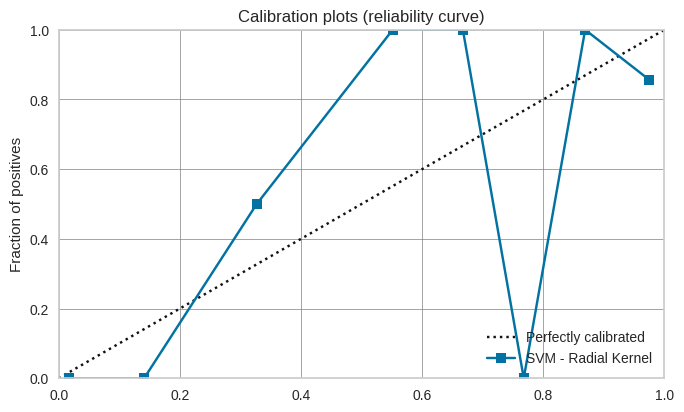

In [ ]:
plot_model(tuned_model1, plot='calibration')

In [ ]:
tuned_model1=tune_model(model1, optimize=OPTIMIZE_FOR,fold=NUM_FOLDS)
score_tuned_model1=pull()
display(tuned_model1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9650  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9301  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8252  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9021  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9301  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8392  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9167  0.9650  0.9231  0.9231  0.9231  0.8322  0.8322
8       0.7917  0.8951  0.8462  0.7857  0.8148  0.5775  0.5795
9       0.8333  0.9510  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9175  0.8692  0.8527  0.8534  0.6707  0.6851
SD      0.0542  0.0493  0.0846  0.0968  0.0453  0.1124  0.1093

SVC(C=0.48, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=-1, probability=True, random_state=123,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
evaluate_model(tuned_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

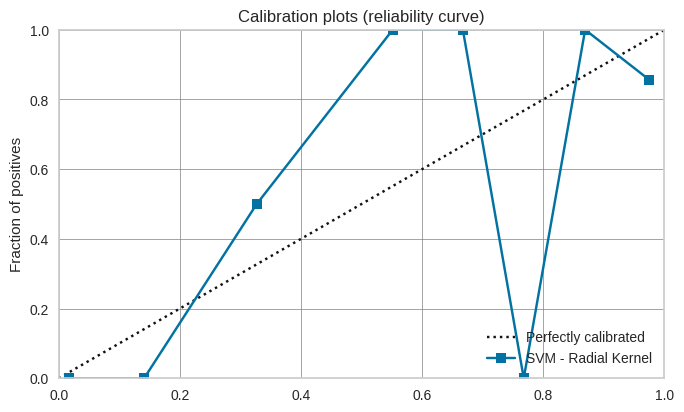

In [ ]:
plot_model(tuned_model1, plot='calibration')

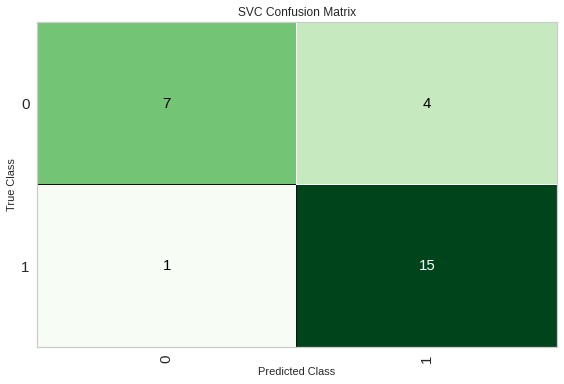

In [ ]:
plot_model(tuned_model1, plot='confusion_matrix')

In [ ]:
calibrated_model1 = calibrate_model(tuned_model1)
score_calibrated_model1=pull()
display(calibrated_model1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9720  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9161  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8182  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9021  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9231  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8392  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9167  0.9720  0.9231  0.9231  0.9231  0.8322  0.8322
8       0.7917  0.8951  0.8462  0.7857  0.8148  0.5775  0.5795
9       0.8333  0.9510  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9161  0.8692  0.8527  0.8534  0.6707  0.6851
SD      0.0542  0.0518  0.0846  0.0968  0.0453  0.1124  0.1093

CalibratedClassifierCV(base_estimator=SVC(C=0.48, break_ties=False,
                                          cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='auto', kernel='rbf',
                                          max_iter=-1, probability=True,
                                          random_state=123, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='sigmoid')

In [ ]:
evaluate_model(calibrated_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

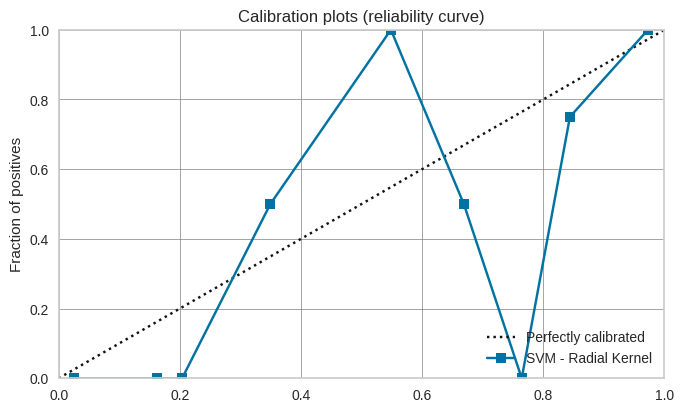

In [ ]:
plot_model(calibrated_model1,plot='calibration')

In [ ]:
bagged_model1 = ensemble_model(calibrated_model1)
score_bagged_model1=pull()

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9790  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9091  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8112  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9161  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9441  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8462  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9583  0.9720  1.0000  0.9286  0.9630  0.9155  0.9188
8       0.7500  0.8951  0.7692  0.7692  0.7692  0.4965  0.4965
9       0.8333  0.9650  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9210  0.8692  0.8516  0.8528  0.6709  0.6855
SD      0.0657  0.0544  0.0976  0.0985  0.0577  0.1348  0.1330

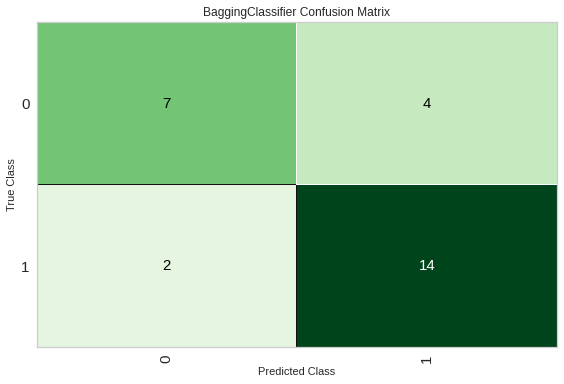

In [ ]:
plot_model(bagged_model1, plot='confusion_matrix')

In [ ]:
boosted_model1 = ensemble_model(calibrated_model1,method = 'Boosting')
score_boosted_model1=pull()

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8750  0.9790  0.8462  0.9167  0.8800  0.7500  0.7526
1       0.8333  0.9231  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7917  0.8671  1.0000  0.7222  0.8387  0.5652  0.6276
4       0.7917  0.9231  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9021  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7500  0.8531  0.6923  0.8182  0.7500  0.5034  0.5105
7       0.9167  0.9720  0.8462  1.0000  0.9167  0.8345  0.8462
8       0.7083  0.9021  0.7692  0.7143  0.7407  0.4085  0.4099
9       0.9167  0.9650  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8333  0.9259  0.8692  0.8451  0.8504  0.6620  0.6775
SD      0.0672  0.0430  0.0913  0.1016  0.0596  0.1373  0.1364

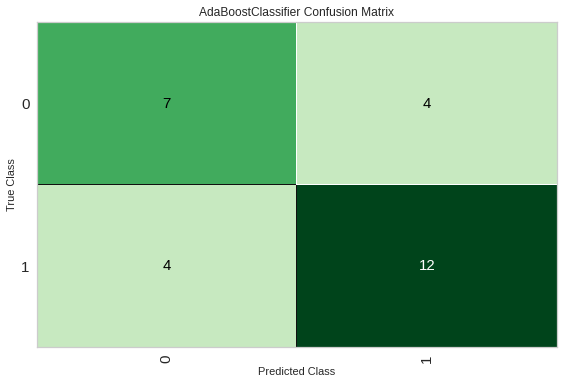

In [ ]:
plot_model(boosted_model1, plot='confusion_matrix')

# Blend Models

In [ ]:
blend_soft = blend_models(estimator_list = [top3[0], top3[1], top3[2]])
score_blend_soft=pull()

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9650  0.9231  0.9231  0.9231  0.8322  0.8322
1       0.8333  0.9021  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9790  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8601  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9091  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9021  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7083  0.8252  0.6923  0.7500  0.7200  0.4167  0.4181
7       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
8       0.7083  0.8881  0.6923  0.7500  0.7200  0.4167  0.4181
9       0.9167  0.9301  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8250  0.9133  0.8615  0.8325  0.8421  0.6456  0.6563
SD      0.0764  0.0471  0.0961  0.0940  0.0707  0.1546  0.1537

In [ ]:
evaluate_model(blend_soft)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

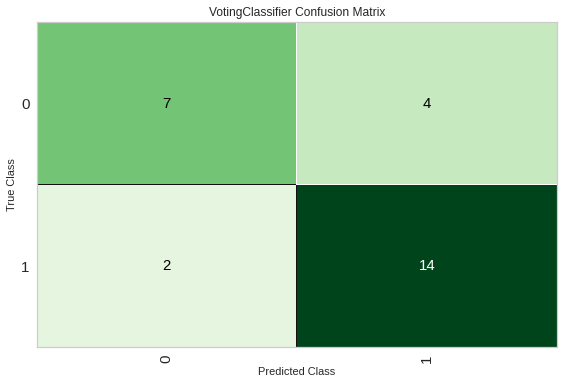

In [ ]:
plot_model(blend_soft, plot='confusion_matrix')

In [ ]:
blend_hard = blend_models(estimator_list = [top3[0], top3[1], top3[2]], method='hard')
score_blend_hard=pull()

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.0  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.0  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.0  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.0  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.0  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.0  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7083  0.0  0.6923  0.7500  0.7200  0.4167  0.4181
7       0.8750  0.0  0.8462  0.9167  0.8800  0.7500  0.7526
8       0.7500  0.0  0.6923  0.8182  0.7500  0.5034  0.5105
9       0.9167  0.0  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8292  0.0  0.8538  0.8470  0.8445  0.6545  0.6669
SD      0.0708  0.0  0.0939  0.0997  0.0652  0.1438  0.1431

In [ ]:
evaluate_model(blend_hard)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

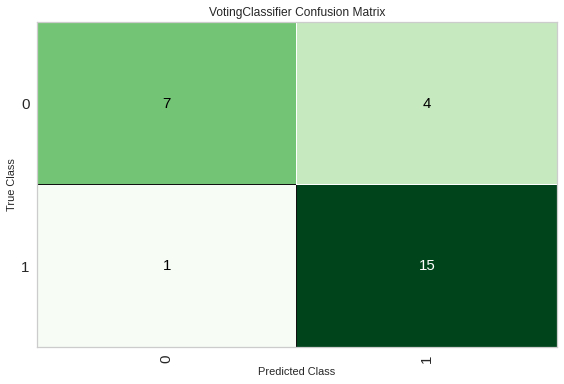

In [ ]:
plot_model(blend_hard, plot='confusion_matrix')

# Model Compare

In [ ]:
#Compare Model Summaries

#Not including base model 1 as tuned model 1 should be no worse
#display('Summary: model1')
#results_model1 = predict_model(model1)

display('Summary: tuned_model1')
display(score_tuned_model1)

display('Prediction: calibrated_model1')
display(score_calibrated_model1)

display('Prediction: bagged_model1')
display(score_bagged_model1)

display('Prediction: boosted_model1')
display(score_boosted_model1)

display('Prediction: blend_soft')
display(score_blend_soft)

display('Prediction: blend_hard')
display(score_blend_hard)



'Summary: tuned_model1'

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9650  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9301  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8252  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9021  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9301  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8392  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9167  0.9650  0.9231  0.9231  0.9231  0.8322  0.8322
8       0.7917  0.8951  0.8462  0.7857  0.8148  0.5775  0.5795
9       0.8333  0.9510  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9175  0.8692  0.8527  0.8534  0.6707  0.6851
SD      0.0542  0.0493  0.0846  0.0968  0.0453  0.1124  0.1093

'Prediction: calibrated_model1'

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9720  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9161  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8182  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9021  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9231  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8392  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9167  0.9720  0.9231  0.9231  0.9231  0.8322  0.8322
8       0.7917  0.8951  0.8462  0.7857  0.8148  0.5775  0.5795
9       0.8333  0.9510  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9161  0.8692  0.8527  0.8534  0.6707  0.6851
SD      0.0542  0.0518  0.0846  0.0968  0.0453  0.1124  0.1093

'Prediction: bagged_model1'

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9790  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.9091  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8112  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9161  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9441  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7917  0.8462  0.7692  0.8333  0.8000  0.5833  0.5854
7       0.9583  0.9720  1.0000  0.9286  0.9630  0.9155  0.9188
8       0.7500  0.8951  0.7692  0.7692  0.7692  0.4965  0.4965
9       0.8333  0.9650  0.6923  1.0000  0.8182  0.6735  0.7125
Mean    0.8375  0.9210  0.8692  0.8516  0.8528  0.6709  0.6855
SD      0.0657  0.0544  0.0976  0.0985  0.0577  0.1348  0.1330

'Prediction: boosted_model1'

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8750  0.9790  0.8462  0.9167  0.8800  0.7500  0.7526
1       0.8333  0.9231  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7917  0.8671  1.0000  0.7222  0.8387  0.5652  0.6276
4       0.7917  0.9231  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9021  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7500  0.8531  0.6923  0.8182  0.7500  0.5034  0.5105
7       0.9167  0.9720  0.8462  1.0000  0.9167  0.8345  0.8462
8       0.7083  0.9021  0.7692  0.7143  0.7407  0.4085  0.4099
9       0.9167  0.9650  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8333  0.9259  0.8692  0.8451  0.8504  0.6620  0.6775
SD      0.0672  0.0430  0.0913  0.1016  0.0596  0.1373  0.1364

'Prediction: blend_soft'

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.9650  0.9231  0.9231  0.9231  0.8322  0.8322
1       0.8333  0.9021  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.9790  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.8601  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.9091  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.9021  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7083  0.8252  0.6923  0.7500  0.7200  0.4167  0.4181
7       0.8750  0.9720  0.8462  0.9167  0.8800  0.7500  0.7526
8       0.7083  0.8881  0.6923  0.7500  0.7200  0.4167  0.4181
9       0.9167  0.9301  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8250  0.9133  0.8615  0.8325  0.8421  0.6456  0.6563
SD      0.0764  0.0471  0.0961  0.0940  0.0707  0.1546  0.1537

'Prediction: blend_hard'

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9167  0.0  0.8462  1.0000  0.9167  0.8345  0.8462
1       0.8333  0.0  0.9231  0.8000  0.8571  0.6596  0.6693
2       0.8750  0.0  0.8462  0.9167  0.8800  0.7500  0.7526
3       0.7500  0.0  0.9231  0.7059  0.8000  0.4820  0.5136
4       0.7917  0.0  0.9231  0.7500  0.8276  0.5714  0.5913
5       0.8750  0.0  1.0000  0.8125  0.8966  0.7429  0.7687
6       0.7083  0.0  0.6923  0.7500  0.7200  0.4167  0.4181
7       0.8750  0.0  0.8462  0.9167  0.8800  0.7500  0.7526
8       0.7500  0.0  0.6923  0.8182  0.7500  0.5034  0.5105
9       0.9167  0.0  0.8462  1.0000  0.9167  0.8345  0.8462
Mean    0.8292  0.0  0.8538  0.8470  0.8445  0.6545  0.6669
SD      0.0708  0.0  0.0939  0.0997  0.0652  0.1438  0.1431

In [ ]:
#Compare Model Prediction Summaries
display('Prediction: model1')
results_model1 = predict_model(model1)
display('Prediction: tuned_model1')
results_tuned_model1 = predict_model(tuned_model1)
display('Prediction: calibrated_model1')
results_calibrated_model1 = predict_model(calibrated_model1)
display('Prediction: bagged_model1')
results_bagged_model1 = predict_model(bagged_model1)
display('Prediction: boosted_model1')
results_boosted_model1 = predict_model(boosted_model1)
display('Prediction: blend_soft_model1')
results_boosted_model1 = predict_model(blend_soft)
display('Prediction: blend_hard_model1')
results_boosted_model1 = predict_model(blend_hard)

'Prediction: model1'

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa    MCC
0  SVM - Radial Kernel    0.7778  0.8295   0.875  0.7778  0.8235  0.5263  0.533

'Prediction: tuned_model1'

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  SVM - Radial Kernel    0.8148  0.8239  ...  0.8571  0.5994  0.6175

[1 rows x 8 columns]

'Prediction: calibrated_model1'

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  SVM - Radial Kernel    0.8148  0.8239  ...  0.8571  0.5994  0.6175

[1 rows x 8 columns]

'Prediction: bagged_model1'

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa    MCC
0  SVM - Radial Kernel    0.7778  0.8182   0.875  0.7778  0.8235  0.5263  0.533

'Prediction: boosted_model1'

Model  Accuracy     AUC  Recall  Prec.    F1   Kappa     MCC
0  SVM - Radial Kernel    0.7037  0.7841    0.75   0.75  0.75  0.3864  0.3864

'Prediction: blend_soft_model1'

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa    MCC
0  Voting Classifier    0.7778  0.8295   0.875  0.7778  0.8235  0.5263  0.533

'Prediction: blend_hard_model1'

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0  Voting Classifier    0.8148  0.7869  0.9375  0.7895  0.8571  0.5994  0.6175

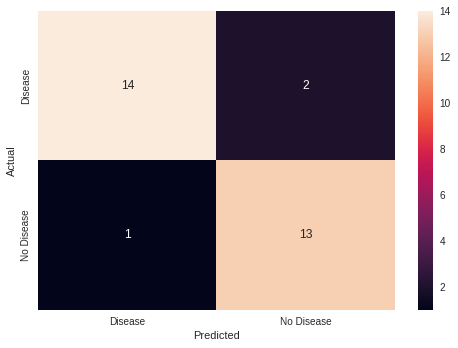

In [ ]:
pred_unseen_model1 = predict_model(model1, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_model1[TARGET_COLUMN], pred_unseen_model1['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

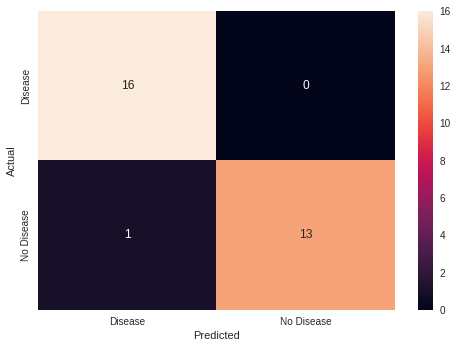

In [ ]:
pred_unseen_tuned_model1 = predict_model(tuned_model1, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_tuned_model1[TARGET_COLUMN], pred_unseen_tuned_model1['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

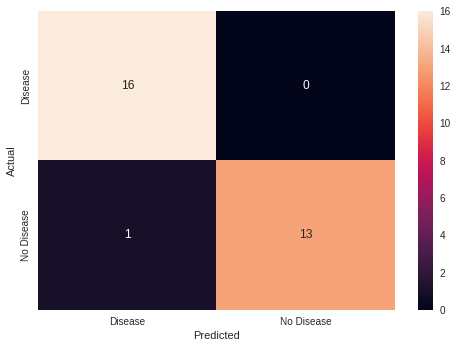

In [ ]:
pred_unseen_calibrated_model1 = predict_model(calibrated_model1, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_calibrated_model1[TARGET_COLUMN], pred_unseen_calibrated_model1['Label'], rownames=['Actual'],colnames=['Predicted']) # , margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

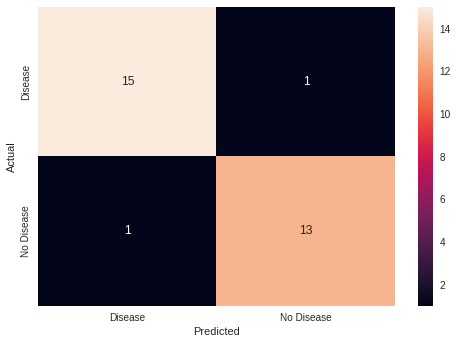

In [ ]:
pred_unseen_bagged_model1 = predict_model(bagged_model1, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_bagged_model1[TARGET_COLUMN], pred_unseen_bagged_model1['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

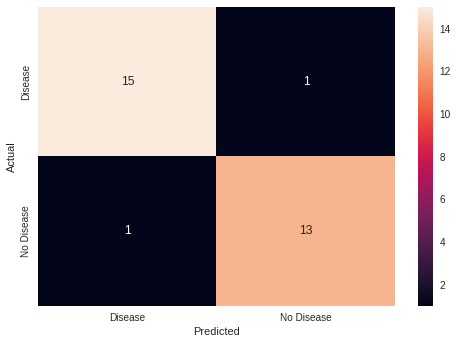

In [ ]:
pred_unseen_boosted_model1 = predict_model(boosted_model1, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_boosted_model1[TARGET_COLUMN], pred_unseen_boosted_model1['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

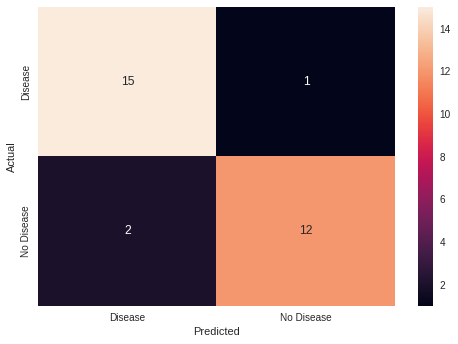

In [ ]:
pred_unseen_blend_soft = predict_model(blend_soft, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_blend_soft[TARGET_COLUMN], pred_unseen_blend_soft['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

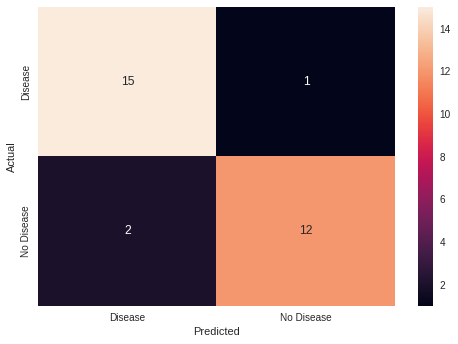

In [ ]:
pred_unseen_blend_hard = predict_model(blend_hard, data=data_unseen)
confusion_matrix_m1 = pd.crosstab(pred_unseen_blend_hard[TARGET_COLUMN], pred_unseen_blend_hard['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()

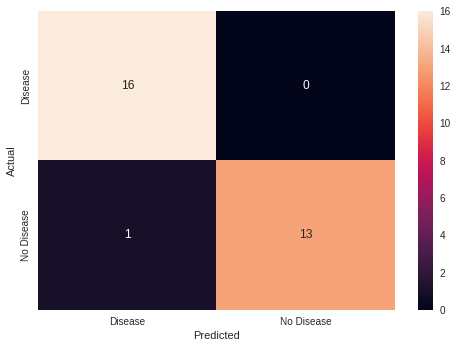

Age  Gender    Chest_Pain  ...  Heart_Disease       Label   Score
0    59    Male       Typical  ...        Disease     Disease  0.5739
1    66    Male      Atypical  ...        Disease     Disease  0.8698
2    59    Male      Atypical  ...     No Disease  No Disease  0.8012
3    56    Male      Atypical  ...     No Disease  No Disease  0.9167
4    68    Male   Not Anginal  ...     No Disease  No Disease  0.5924
5    67  Female   Not Anginal  ...     No Disease  No Disease  0.8513
6    66  Female   Not Anginal  ...     No Disease  No Disease  0.6959
7    59    Male   Not Anginal  ...        Disease     Disease  0.6090
8    58    Male   Not Anginal  ...        Disease     Disease  0.6373
9    50    Male   Not Anginal  ...     No Disease  No Disease  0.9033
10   46  Female   Not Anginal  ...     No Disease  No Disease  0.8151
11   44  Female   Not Anginal  ...     No Disease  No Disease  0.7958
12   44    Male   Not Anginal  ...     No Disease  No Disease  0.9109
13   44    Male   Not Anginal  ...     No Disease  No Disease  0.9245
14   39  Female   Not Anginal  ...     No Disease  No Disease  0.8261
15   70    Male  Asymptomatic  ...        Disease     Disease  0.8967
16   64  Female  Asymptomatic  ...     No Disease     Disease  0.8340
17   62  Female  Asymptomatic  ...     No Disease  No Disease  0.8433
18   61    Male  Asymptomatic  ...        Disease     Disease  0.9255
19   60    Male  Asymptomatic  ...        Disease     Disease  0.9641
20   60    Male  Asymptomatic  ...        Disease     Disease  0.8336
21   58  Female  Asymptomatic  ...     No Disease  No Disease  0.6314
22   56    Male  Asymptomatic  ...        Disease     Disease  0.8391
23   56    Male  Asymptomatic  ...        Disease     Disease  0.7100
24   52    Male  Asymptomatic  ...        Disease     Disease  0.6847
25   48    Male  Asymptomatic  ...        Disease     Disease  0.8563
26   47    Male  Asymptomatic  ...        Disease     Disease  0.7591
27   46    Male  Asymptomatic  ...        Disease     Disease  0.5208
28   42    Male  Asymptomatic  ...        Disease     Disease  0.7814
29   40    Male  Asymptomatic  ...        Disease     Disease  0.8285

[30 rows x 16 columns]

In [ ]:
results_model = predict_model(calibrated_model1, data=data_unseen)
holdout_score=pull()
confusion_matrix_m1 = pd.crosstab(results_model[TARGET_COLUMN], results_model['Label'], rownames=['Actual'],colnames=['Predicted'])  #, margins=True)
sns.heatmap(confusion_matrix_m1, annot=True)
plt.show()
display(results_model)